# Benchmark results reporting

## Setup

### Prerequirements
This notebook requires a kernel running Python 3.5+.
You can skip this section if the kernel is already configured.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

### Imports and selection of the results directory

In [31]:
from IPython import display as idisplay
import functools as ft
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')


In [32]:
results_dir = "./stable"
import os
print("current working dir: {}".format(os.getcwd()))
try:
    os.chdir(results_dir)
except:
    pass
os.getcwd()

current working dir: /Users/seb/repos/ml/automlbenchmark/stable


'/Users/seb/repos/ml/automlbenchmark/stable'

## Results

Loading results, formatting and adding columns:
- `result` is the raw result metric computed from predictions at the end the benchmark.
    For classification problems, it is usually `auc` for binomial classification and `logloss` for multinomial classification.
- `error` ensures a standard comparison between tasks: lower is always better.
- `norm_error` is a normalization of `error` on a `[0, 1]` scale, due to `logloss` especially that can take any positive value.

In [33]:
def display(fr):
    if type(fr) is pd.Series:
        fr = fr.to_frame()
    if type(fr) is pd.DataFrame:
        idisplay.display(idisplay.HTML(fr.to_html()))
    else:
        print(fr)

        
def build_classification_type_map(results):
    cp = results.loc[(results.framework=='constantpredictor')&(results.fold==0)]
    binary_tasks = cp.where(pd.notna(cp.auc))['task'].dropna().tolist()
    cp = all_results.loc[(all_results.framework=='constantpredictor')&(all_results.fold==0)]
    return cp.apply(lambda r: pd.Series([r.task, 'binary' if not np.isnan(r.auc) else 'multiclass'], 
                                        index=['task', 'type']), 
                    axis=1,
                    result_type='expand')\
             .set_index('task')['type']\
             .to_dict()    
    
def classification_type(row, type_map):
    return type_map.get(row.task)

def err(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result
    
def norm_err(row):
    return 1 - row.result if row.result in [row.auc, row.acc]\
           else row.result / (1+row.result)

all_results = pd.read_csv('results.csv')\
                .replace('constantpredictor_enc', 'constantpredictor')
all_results.task = all_results.task.str.lower()
all_results.framework = all_results.framework.str.lower()
all_results.fold = all_results.fold.apply(int)
class_type_map = build_classification_type_map(all_results)
all_results['type'] = [classification_type(row, class_type_map) for _, row in all_results.iterrows()]
# all_results['error'] = 1 - all_results['acc']
all_results['error'] = [err(row) for _, row in all_results.iterrows()]
all_results['norm_error'] = [norm_err(row) for _, row in all_results.iterrows()]

all_frameworks = all_results.framework.unique()
all_tasks = all_results.task.unique()
all_folds = all_results.fold.unique()
sorted_ints = lambda arr: sorted(list(map(int, arr[~np.isnan(arr)])))

### Completed tasks/folds

In [34]:
done = all_results.groupby(['task', 'framework'])['fold'].unique()
display(done)

### Missing or crashed/aborted tasks/folds

In [35]:
nfolds = 10
not_done = pd.DataFrame([(task, framework) for task in all_tasks 
                                           for framework in all_frameworks 
                                           if (task, framework) not in done.index],
                        columns=['task', 'framework'])
missing = all_results.append(not_done).groupby(['task', 'framework'])['fold']\
                     .unique()\
                     .map(sorted_ints)\
                     .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
                     .where(lambda values: values.map(lambda arr: len(arr) > 0))\
                     .dropna()
display(missing)

### Failing tasks/folds

In [36]:
failed = all_results.where(np.isnan(all_results.result))\
                    .groupby(['task', 'framework'])['fold']\
                    .unique()\
                    .map(sorted_ints)
display(failed)

## Data reports

### Results summary

Averaging using arithmetic mean over fold `result` or `error`.

In [37]:
res = all_results.groupby(['type', 'task', 'framework'])
mean_res_df = res['result'].mean().unstack()
mean_err_df = res['error'].mean().unstack()
mean_norm_err_df = res['norm_error'].mean().unstack()

#### Results mean

In [38]:
display(mean_res_df)

#### Error mean

In [39]:
display(mean_err_df)

In [40]:
mean_res_df.to_csv("result_summary.csv", float_format='%.6g')
mean_err_df.to_csv("error_summary.csv", float_format='%.6g')
mean_norm_err_df.to_csv("norm_error_summary.csv", float_format='%.6g')

### Tasks leaderboard

In [41]:
def rank(errors):
    sorted_errors = np.sort(errors.unique())
    ranks = pd.Series(index=errors.index)
    for idx, value in errors.items():
        try:
            ranks.at[idx] = np.where(sorted_errors == value)[0][0] + 1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

In [42]:
task_leaderboard_df = mean_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
task_leaderboard_df.astype(float).to_csv('tasks_leaderboard.csv', float_format='%.f')
display(task_leaderboard_df)

### Folds leaderboard

In [43]:
folds_err_df = all_results.pivot_table(index=['type','task', 'fold'], columns='framework', values='error')
folds_leaderboard_df = folds_err_df.apply(rank, axis=1, result_type='broadcast').astype(object)
folds_leaderboard_df.astype(float).to_csv('folds_leaderboard.csv', float_format='%.f')
display(folds_leaderboard_df)

## Visualizations

In [44]:
def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    
def task_labels(index):
    max_length = 16
    return index.droplevel('type')\
                .map(lambda x: x if len(x) <= max_length else u'{}…'.format(x[:max_length-1]))\
                .values
    
def draw_heatmap(df, x_labels=True, y_labels=True):
    sb.set(style="whitegrid")
    hm = sb.heatmap(df, xticklabels=x_labels, yticklabels=y_labels, annot=True, cmap='YlOrBr')
    hm.figure.set_size_inches(8, 8)
    hm.figure.set_dpi(120)
    return hm.figure

def draw_parallel_coord(df, class_column, x_labels=None, yscale='linear', legend_loc='best'):
    parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, 8))
    axes = pd.plotting.parallel_coordinates(df, 
                                            class_column=class_column, 
                                            colormap='tab10')
    axes.set_yscale(yscale)
    axes.set_xticklabels(x_labels)
    axes.tick_params(axis='x', labelrotation=90) 
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc=legend_loc)
    return parallel_fig

def draw_stripplot(df, x, y, hue, xscale='linear', xbound=None, legend_loc='best'):
    sb.set(style="whitegrid")

    # Initialize the figure
    strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(8, 12))
    axes.set_xscale(xscale)
    if xbound is not None:   
        axes.set_autoscalex_on(False)
        axes.set_xbound(*xbound)
#     axes.invert_xaxis()
    sb.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sb.stripplot(x=x, y=y, hue=hue,
                 data=df, dodge=True, jitter=True,
                 alpha=.25, zorder=1)

    # Show the conditional means
    sb.pointplot(x=x, y=y, hue=hue,
                 data=df, dodge=.5, join=False, palette="tab10",
                 markers="d", scale=.75, ci=None)

    # Improve the legend 
    handles, labels = axes.get_legend_handles_labels()
    dist = int(len(labels)/2)
    axes.legend(handles[dist:], labels[dist:], title=hue,
                handletextpad=0, columnspacing=1,
                loc=legend_loc, ncol=1, frameon=True)
    return strip_fig

### Heatmaps

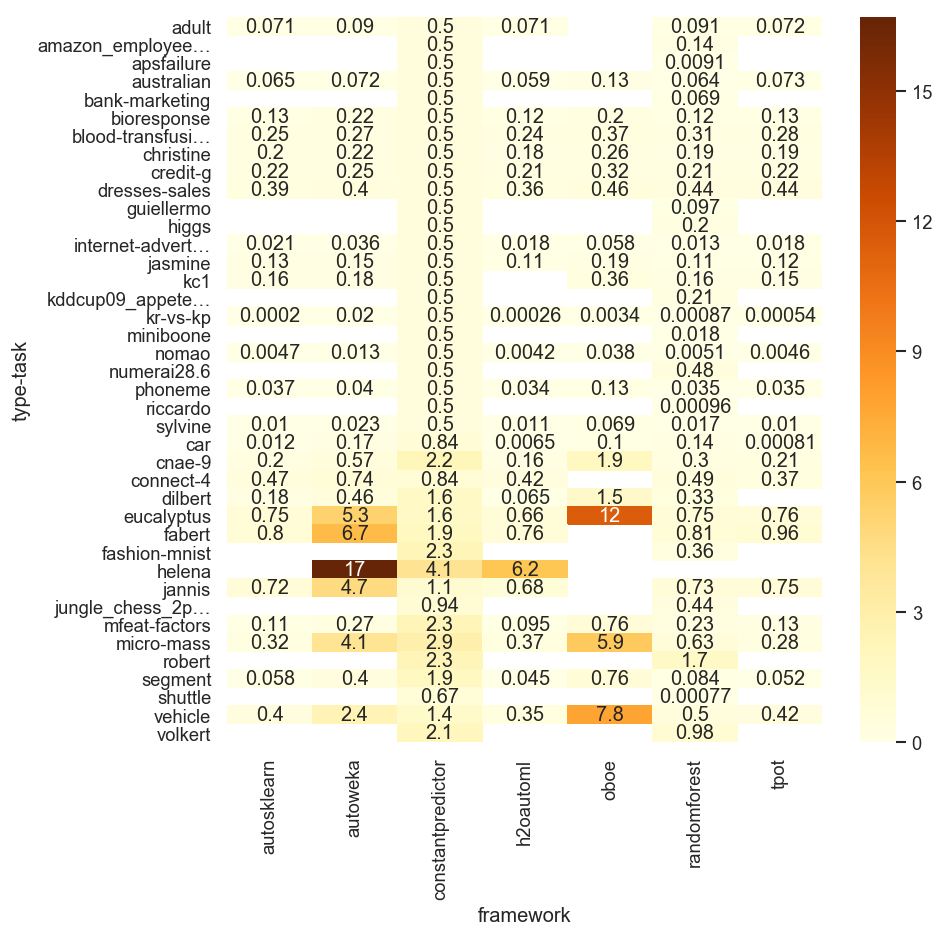

In [45]:
heat_err_fig = draw_heatmap(mean_err_df, y_labels=task_labels(mean_err_df.index))

In [46]:
savefig(heat_err_fig, "heat_error.png")

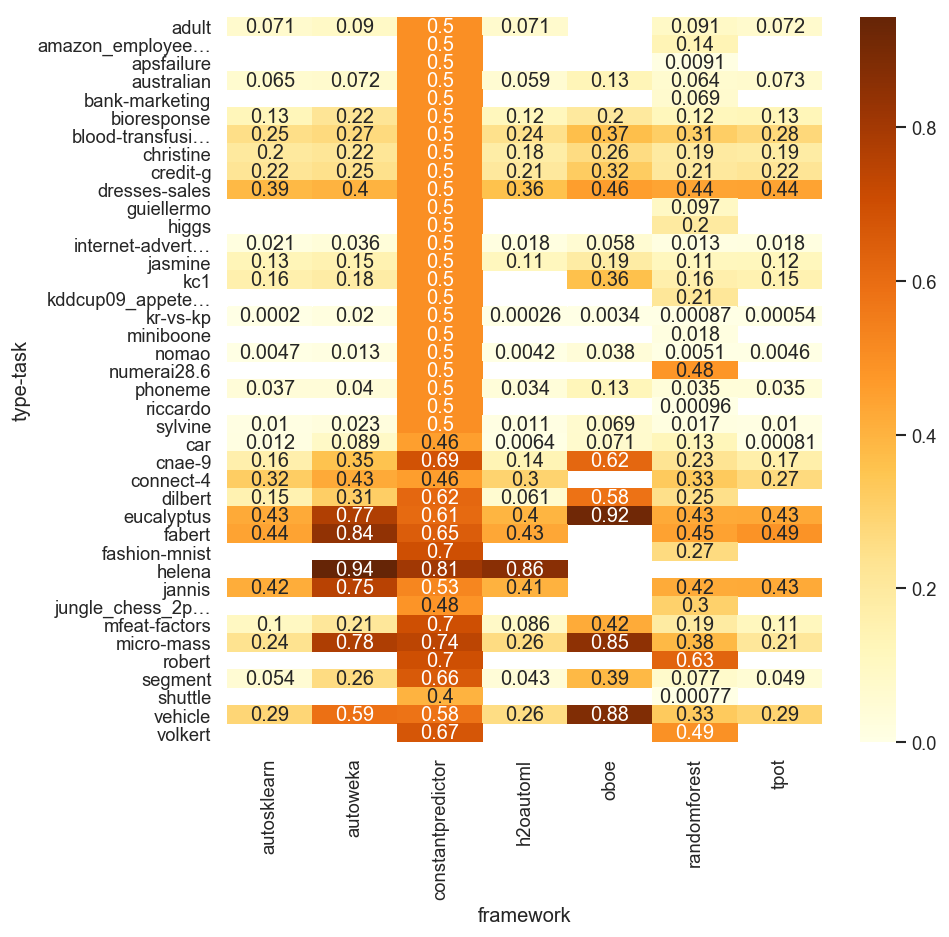

In [47]:
heat_norm_err_fig = draw_heatmap(mean_norm_err_df, y_labels=task_labels(mean_norm_err_df.index))

In [48]:
savefig(heat_norm_err_fig, "heat_norm_error.png")

### Linear plots

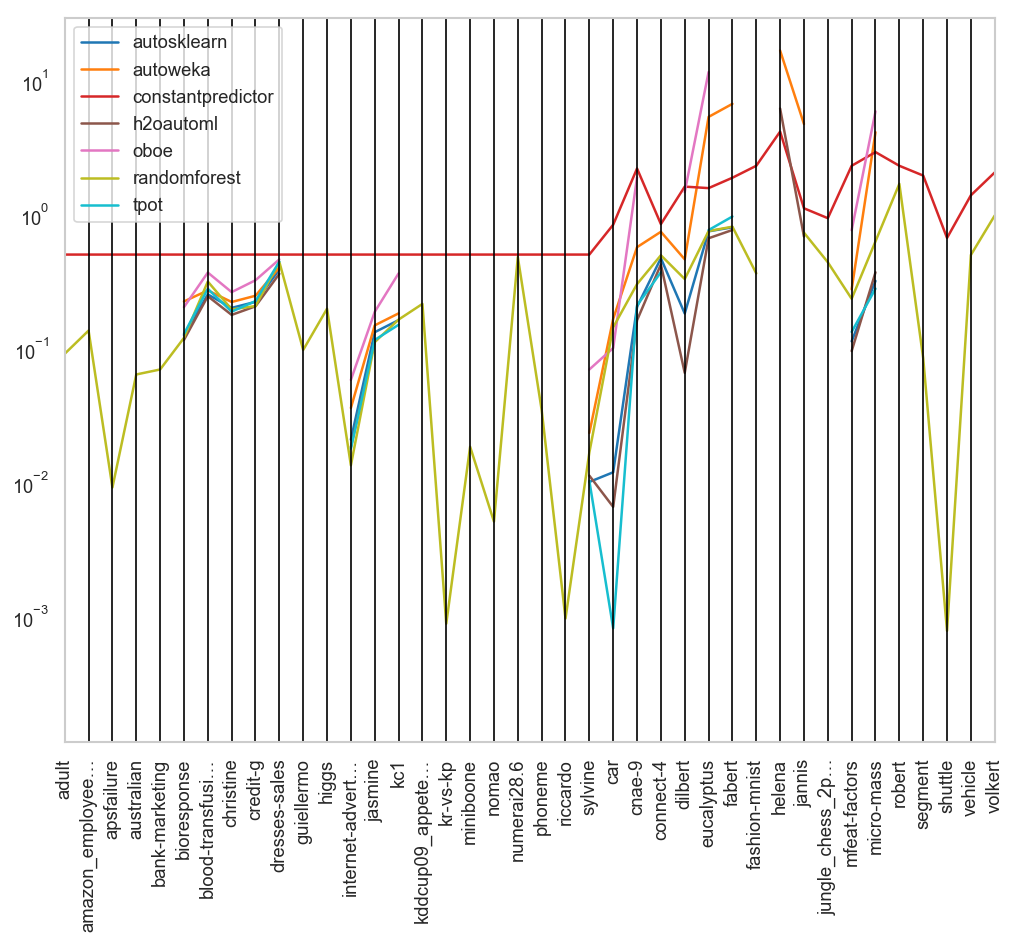

In [49]:
mean_err_parallel_df = res['error'].mean().unstack(['type', 'task'])
mean_err_parallel_df.reset_index(inplace=True)
parallel_err_log_fig = draw_parallel_coord(mean_err_parallel_df, 'framework',
                                           x_labels=task_labels(mean_err_parallel_df.columns.drop('framework')), 
                                           legend_loc='upper left',
                                           yscale='log')

In [50]:
savefig(parallel_err_log_fig, "parallel_coordinates_error_log.png")

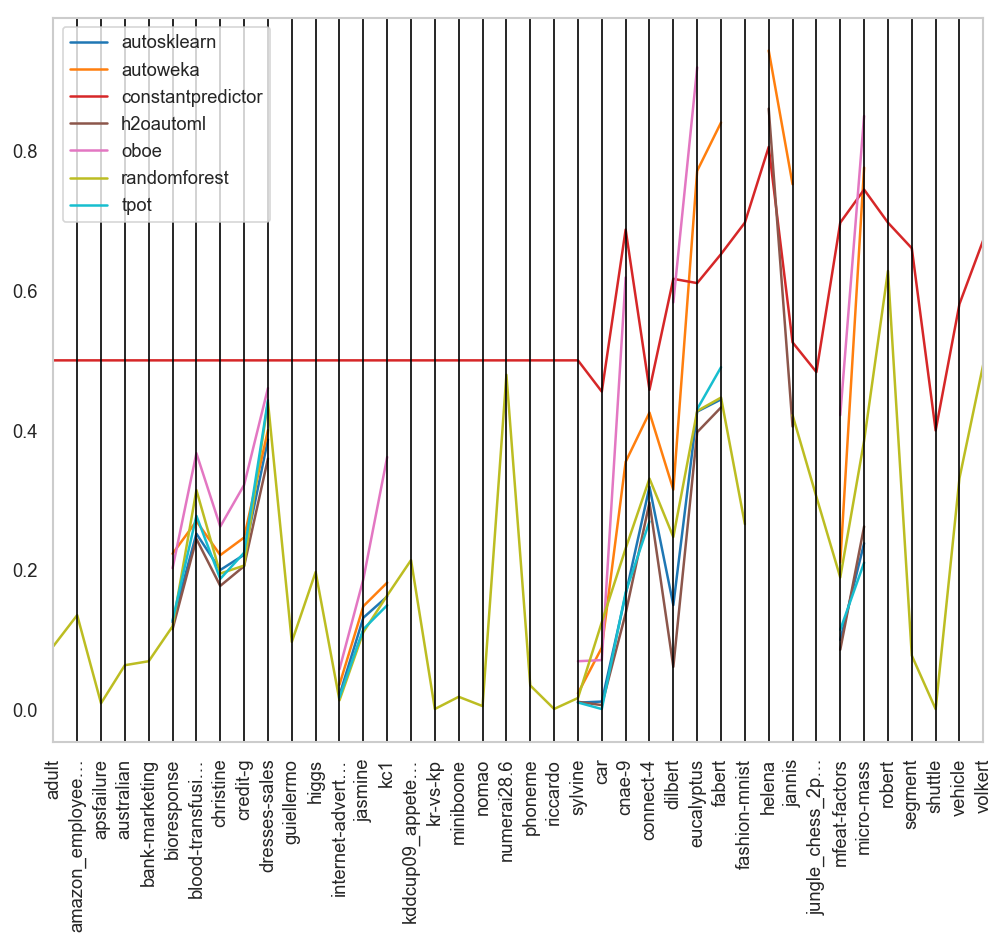

In [51]:
mean_norm_err_parallel_df = res['norm_error'].mean().unstack(['type', 'task'])
mean_norm_err_parallel_df.reset_index(inplace=True)
parallel_norm_err_fig = draw_parallel_coord(mean_norm_err_parallel_df, 'framework',
                                            legend_loc='upper left',
                                            x_labels=task_labels(mean_norm_err_parallel_df.columns.drop('framework')))

### Scatterplots

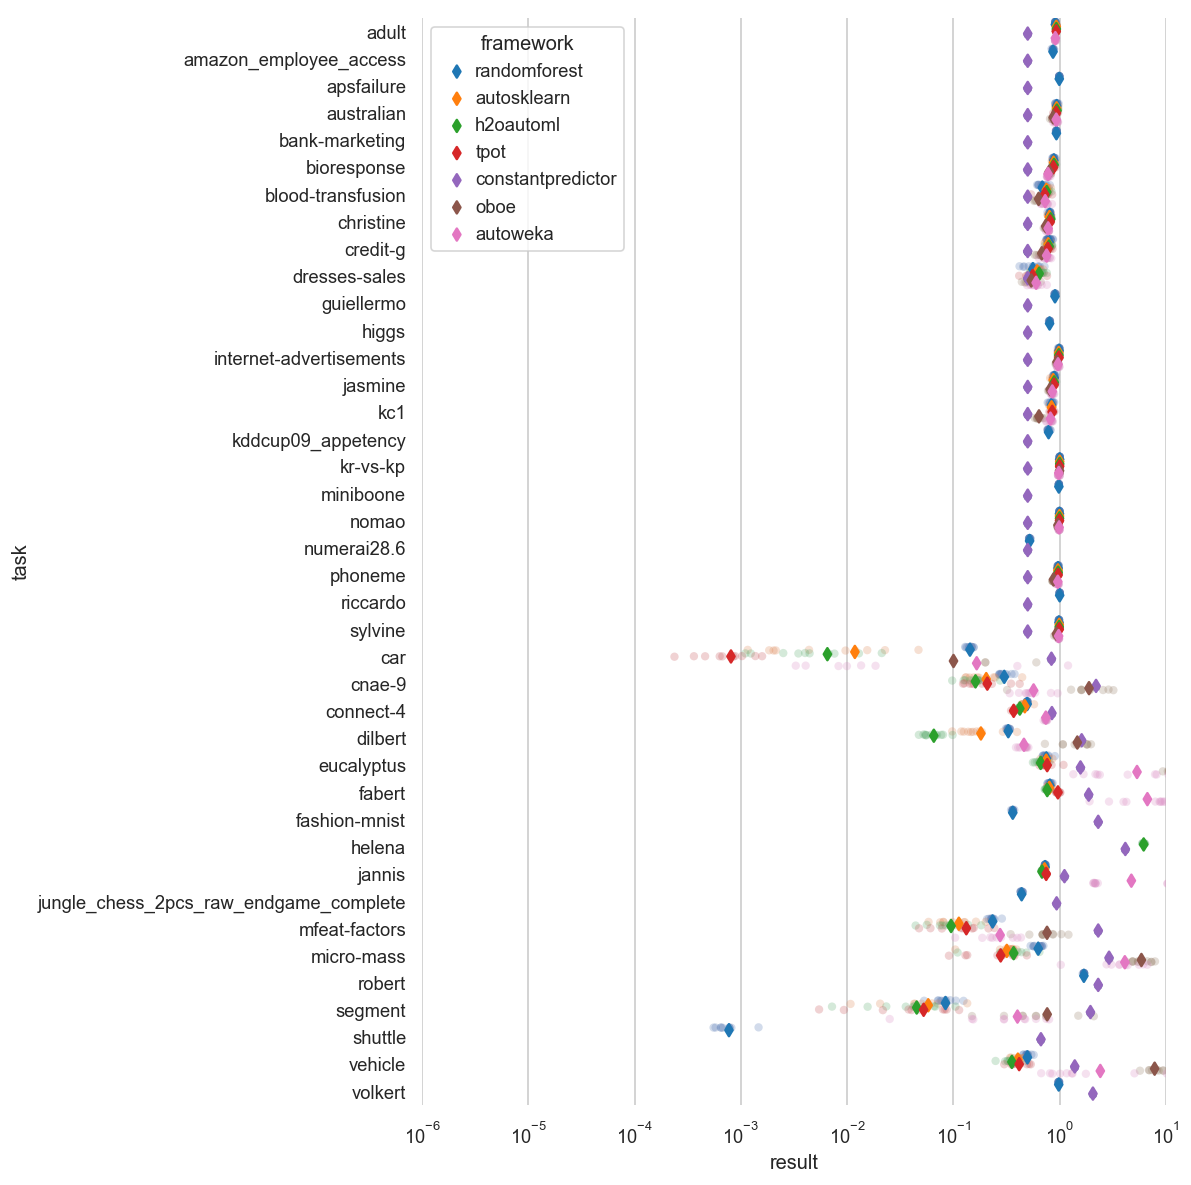

In [52]:
strip_err_log_fig = draw_stripplot(
    all_results.sort_values(by=['type', 'task']),
    x='result',
    y='task',
    hue='framework',
    xscale='log',
    xbound=(1e-6, 10),
    legend_loc='bottom left'
)

In [53]:
savefig(strip_err_log_fig, "stripplot_error_log.png")

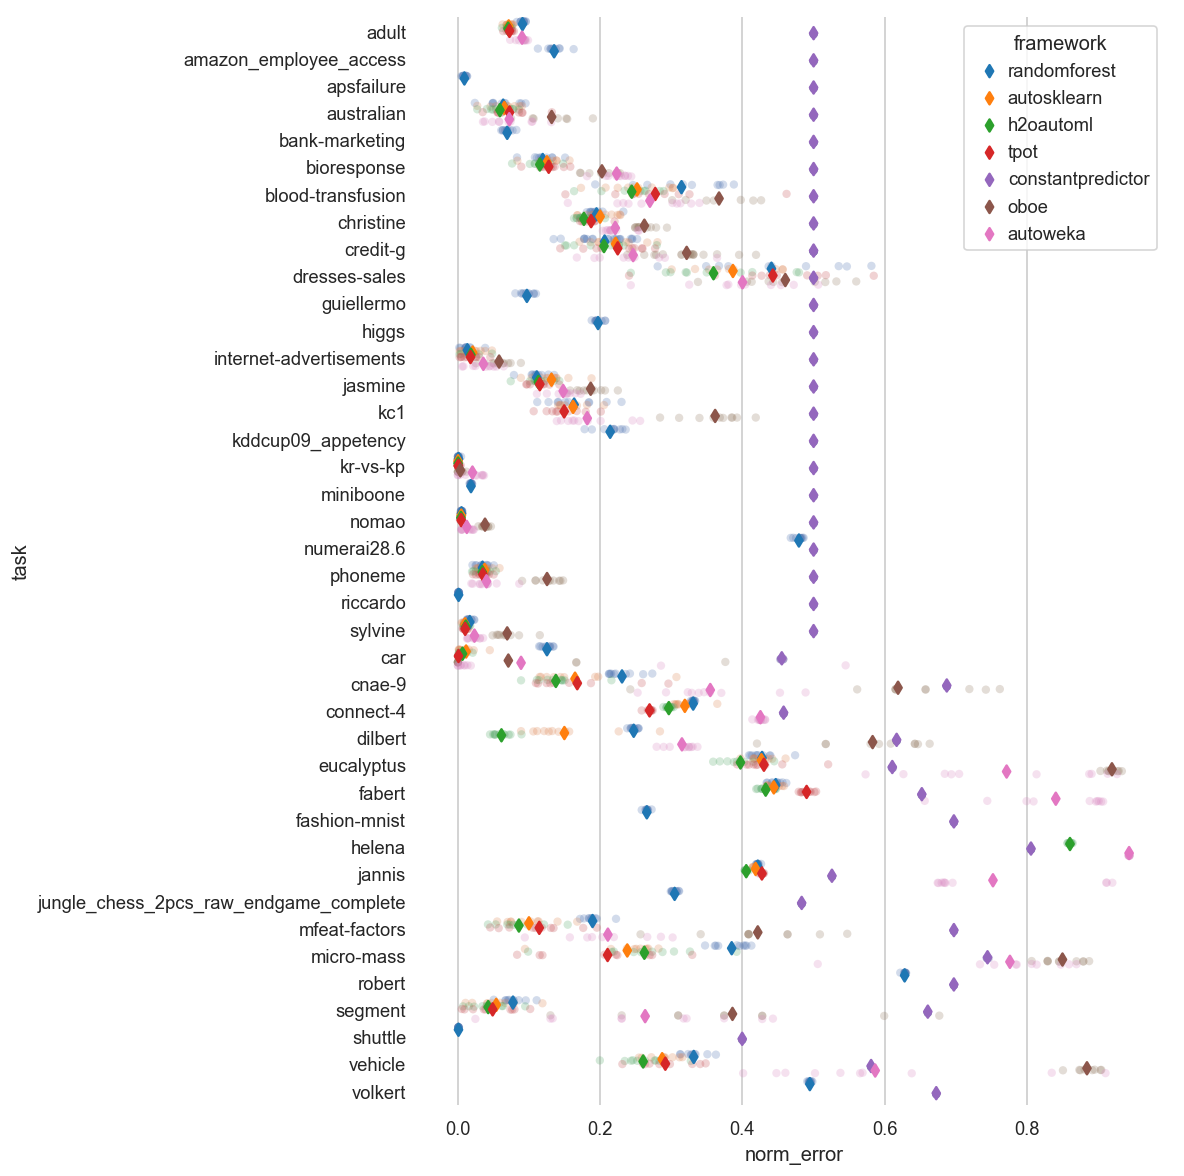

In [54]:
strip_norm_err_fig = draw_stripplot(
    all_results.sort_values(by=['type','task']),
    x='norm_error',
    y='task',
    hue='framework',
#     xscale='symlog',
    legend_loc='upper right'
)

In [55]:
savefig(strip_norm_err_fig, "stripplot_norm_error.png")

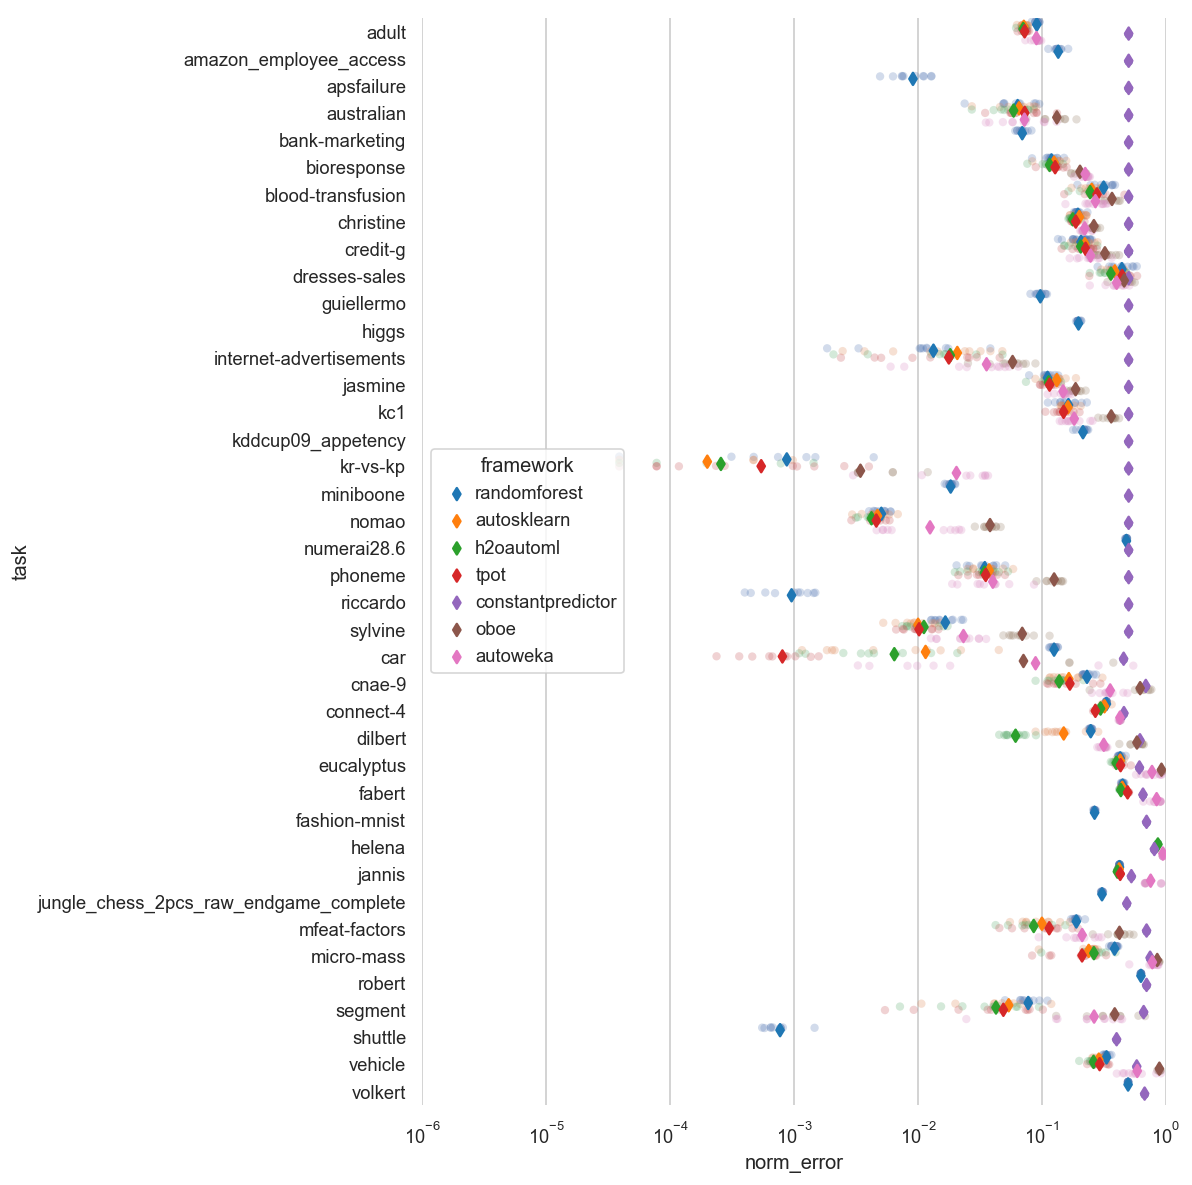

In [56]:
strip_norm_err_log_fig = draw_stripplot(
    all_results.sort_values(by=['type','task']),
    x='norm_error',
    y='task',
    hue='framework',
#     xscale='logit',
    xscale='log',
    xbound=(1e-6, 1),
    legend_loc='center left'
)

In [57]:
savefig(strip_norm_err_log_fig, "stripplot_norm_error_log.png")

## Playground

In [58]:
all_results.loc[(all_results.task=='dilbert')&(all_results.framework=='randomforest')];

In [59]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints);

In [60]:
failures = all_results.loc[np.isnan(all_results.result)]\
                    .groupby(['task', 'fold', 'framework'])['info']\
                    .unique();
#display(failures)